In [1]:
!pip install yfinance


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     --- ------------------------------------ 0.3/3.0 MB 17.7 MB/s eta 0:00:01
     ------- -------------------------------- 0.5/3.0 MB 8.4 MB/s eta 0:00:01
     --------------- ------------------------ 1.2/3.0 MB 10.5 MB/s eta 0:00:01
     ------------------------ --------------- 1.8/3.0 MB 11.7 MB/s eta 0:00:01
     ------------------------------ --------- 2.3/3.0 MB 11.1 MB/s eta 0:00:01
     ---------------------------------------  2.9/3.0 MB 12.6 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 11.8 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml

In [11]:
import yfinance as yf
from datetime import date, timedelta

# define the time period for the data
end_date = date.today().strftime("%Y-%m-%d")
start_date = (date.today() - timedelta(days=365)).strftime("%Y-%m-%d")

# list of stock tickers to download
tickers = ['AAPL', 'MSFT', 'NFLX', 'GOOG', 'TSLA']

# download the stock data
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# reset index to bring Date into the columns
data = data.reset_index()

# flatten the MultiIndex columns
data.columns = [' '.join(col).strip() if type(col) is tuple else col for col in data.columns]

# melt the DataFrame to make it long format where each row is a unique combination of Date, Ticker, and attributes
data_melted = data.melt(id_vars=['Date'], var_name='Attribute_Ticker', value_name='Value')

# split the Attribute_Ticker into separate columns
data_melted[['Attribute', 'Ticker']] = data_melted['Attribute_Ticker'].str.rsplit(' ', n=1, expand=True)

# pivot the melted DataFrame to have the attributes (Open, High, Low, etc.) as columns
data_pivoted = data_melted.pivot_table(index=['Date', 'Ticker'], columns='Attribute', values='Value', aggfunc='first')

# reset index to turn multi-index into columns
stock_data = data_pivoted.reset_index()

print(stock_data.head())


Attribute       Date Ticker   Adj Close       Close        High         Low  \
0         2023-07-24   AAPL  191.731750  192.750000  194.910004  192.250000   
1         2023-07-24   GOOG  121.741463  121.879997  123.349998  121.379997   
2         2023-07-24   MSFT  342.431244  345.109985  346.920013  342.309998   
3         2023-07-24   NFLX  428.369995  428.369995  428.640015  419.190002   
4         2023-07-24   TSLA  269.059998  269.059998  269.850006  254.119995   

Attribute        Open       Volume  
0          193.410004   45377800.0  
1          121.926003   22276100.0  
2          345.850006   26678100.0  
3          425.000000    8264400.0  
4          255.850006  136508500.0  


In [12]:
# convert the 'Date' column to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# set the 'Date' column as the index of the dataframe
stock_data.set_index('Date', inplace=True)
print(stock_data.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-07-24   AAPL  191.731750  192.750000  194.910004  192.250000  193.410004   
2023-07-24   GOOG  121.741463  121.879997  123.349998  121.379997  121.926003   
2023-07-24   MSFT  342.431244  345.109985  346.920013  342.309998  345.850006   
2023-07-24   NFLX  428.369995  428.369995  428.640015  419.190002  425.000000   
2023-07-24   TSLA  269.059998  269.059998  269.850006  254.119995  255.850006   

Attribute        Volume  
Date                     
2023-07-24   45377800.0  
2023-07-24   22276100.0  
2023-07-24   26678100.0  
2023-07-24    8264400.0  
2023-07-24  136508500.0  


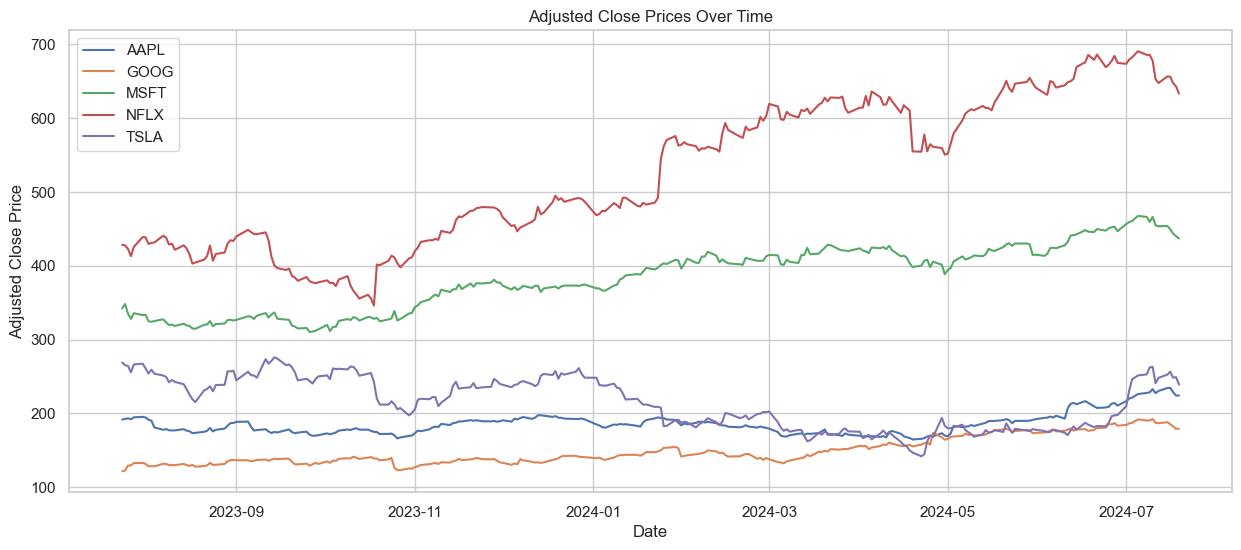

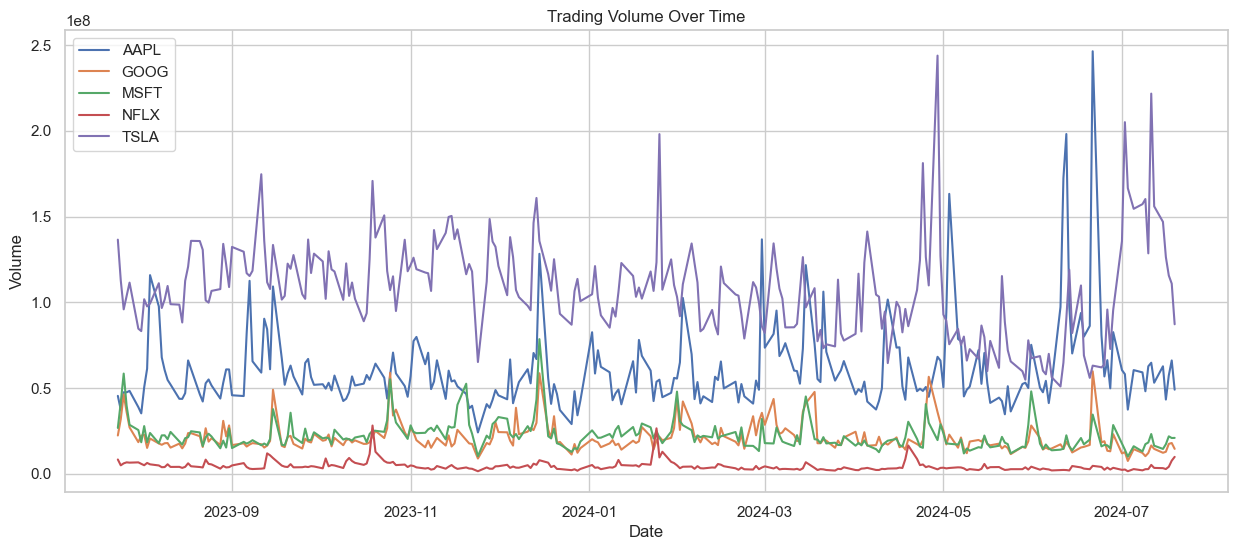

In [14]:
#Visualization Using python libraries 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# plotting the adjusted close prices for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Adj Close'], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

# plotting the trading volume for each ticker over time
plt.figure(figsize=(15, 6))
for ticker in stock_data['Ticker'].unique():
    subset = stock_data[stock_data['Ticker'] == ticker]
    plt.plot(subset.index, subset['Volume'], label=ticker)

plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [15]:
# #The first graph shows the adjusted closing prices of five different stocks:

# AAPL (Apple Inc.)
# GOOG (Alphabet Inc.)
# MSFT (Microsoft Corporation)
# NFLX (Netflix, Inc.)
# and TSLA (Tesla, Inc.)
# GOOG appears to have the highest price and shows a general uptrend throughout the period, despite some volatility. 
# TSLA and AAPL also exhibit an uptrend, with AAPL’s stock price increasing more steadily. MSFT and NFLX display relatively lower prices compared to the others, 
# with NFLX showing considerable fluctuation but remaining mostly flat, and MSFT demonstrating a slight downtrend towards the end of the period.

# From the second graph, it is evident that AAPL and TSLA have the highest and most volatile trading volumes,
# with TSLA showing particularly large spikes. It suggests significant investor interest or reactions to events during those times. 
# GOOG, while having the highest stock price, shows moderate and relatively stable trading volume. 
# MSFT and NFLX have lower and less volatile trading volumes in comparison to AAPL and TSLA. 
# The spikes and dips in trading volumes could correspond to earnings reports, product announcements, or other market-moving events for these companies.

In [16]:
#computing the Z-scores for both the adjusted close prices and trading volumes for each stock and then identify any data points that exceed this threshold
from scipy.stats import zscore

def detect_anomalies(df, column):
    df_copy = df.copy()

    # calculate Z-scores and add them as a new column
    df_copy['Z-score'] = zscore(df_copy[column])

    # find where the absolute Z-score is greater than 2 (common threshold for anomalies)
    anomalies = df_copy[abs(df_copy['Z-score']) > 2]
    return anomalies

anomalies_adj_close = pd.DataFrame()
anomalies_volume = pd.DataFrame()

for ticker in stock_data['Ticker'].unique():
    data_ticker = stock_data[stock_data['Ticker'] == ticker]

    adj_close_anomalies = detect_anomalies(data_ticker, 'Adj Close')
    volume_anomalies = detect_anomalies(data_ticker, 'Volume')

    # use concat instead of append
    anomalies_adj_close = pd.concat([anomalies_adj_close, adj_close_anomalies])
    anomalies_volume = pd.concat([anomalies_volume, volume_anomalies])

print(anomalies_adj_close.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2024-06-17   AAPL  216.669998  216.669998  218.949997  212.720001  213.369995   
2024-07-01   AAPL  216.750000  216.750000  217.509995  211.919998  212.089996   
2024-07-02   AAPL  220.270004  220.270004  220.380005  215.100006  216.149994   
2024-07-03   AAPL  221.550003  221.550003  221.550003  219.029999  220.000000   
2024-07-05   AAPL  226.339996  226.339996  226.449997  221.649994  221.649994   

Attribute       Volume   Z-score  
Date                              
2024-06-17  93728300.0  2.105151  
2024-07-01  60402900.0  2.110585  
2024-07-02  58046200.0  2.349670  
2024-07-03  37369800.0  2.436609  
2024-07-05  60412400.0  2.761954  


In [17]:
print(anomalies_volume.head())

Attribute  Ticker   Adj Close       Close        High         Low        Open  \
Date                                                                            
2023-08-04   AAPL  181.028610  181.990005  187.380005  181.919998  185.520004   
2023-09-07   AAPL  176.860519  177.559998  178.210007  173.539993  175.179993   
2023-12-15   AAPL  197.050949  197.570007  198.399994  197.000000  197.529999   
2024-02-29   AAPL  180.505173  180.750000  182.570007  179.529999  181.270004   
2024-03-15   AAPL  172.386185  172.619995  172.619995  170.289993  171.169998   

Attribute        Volume   Z-score  
Date                               
2023-08-04  115799700.0  2.241467  
2023-09-07  112488800.0  2.107221  
2023-12-15  128256700.0  2.746560  
2024-02-29  136682600.0  3.088203  
2024-03-15  121664700.0  2.479275  


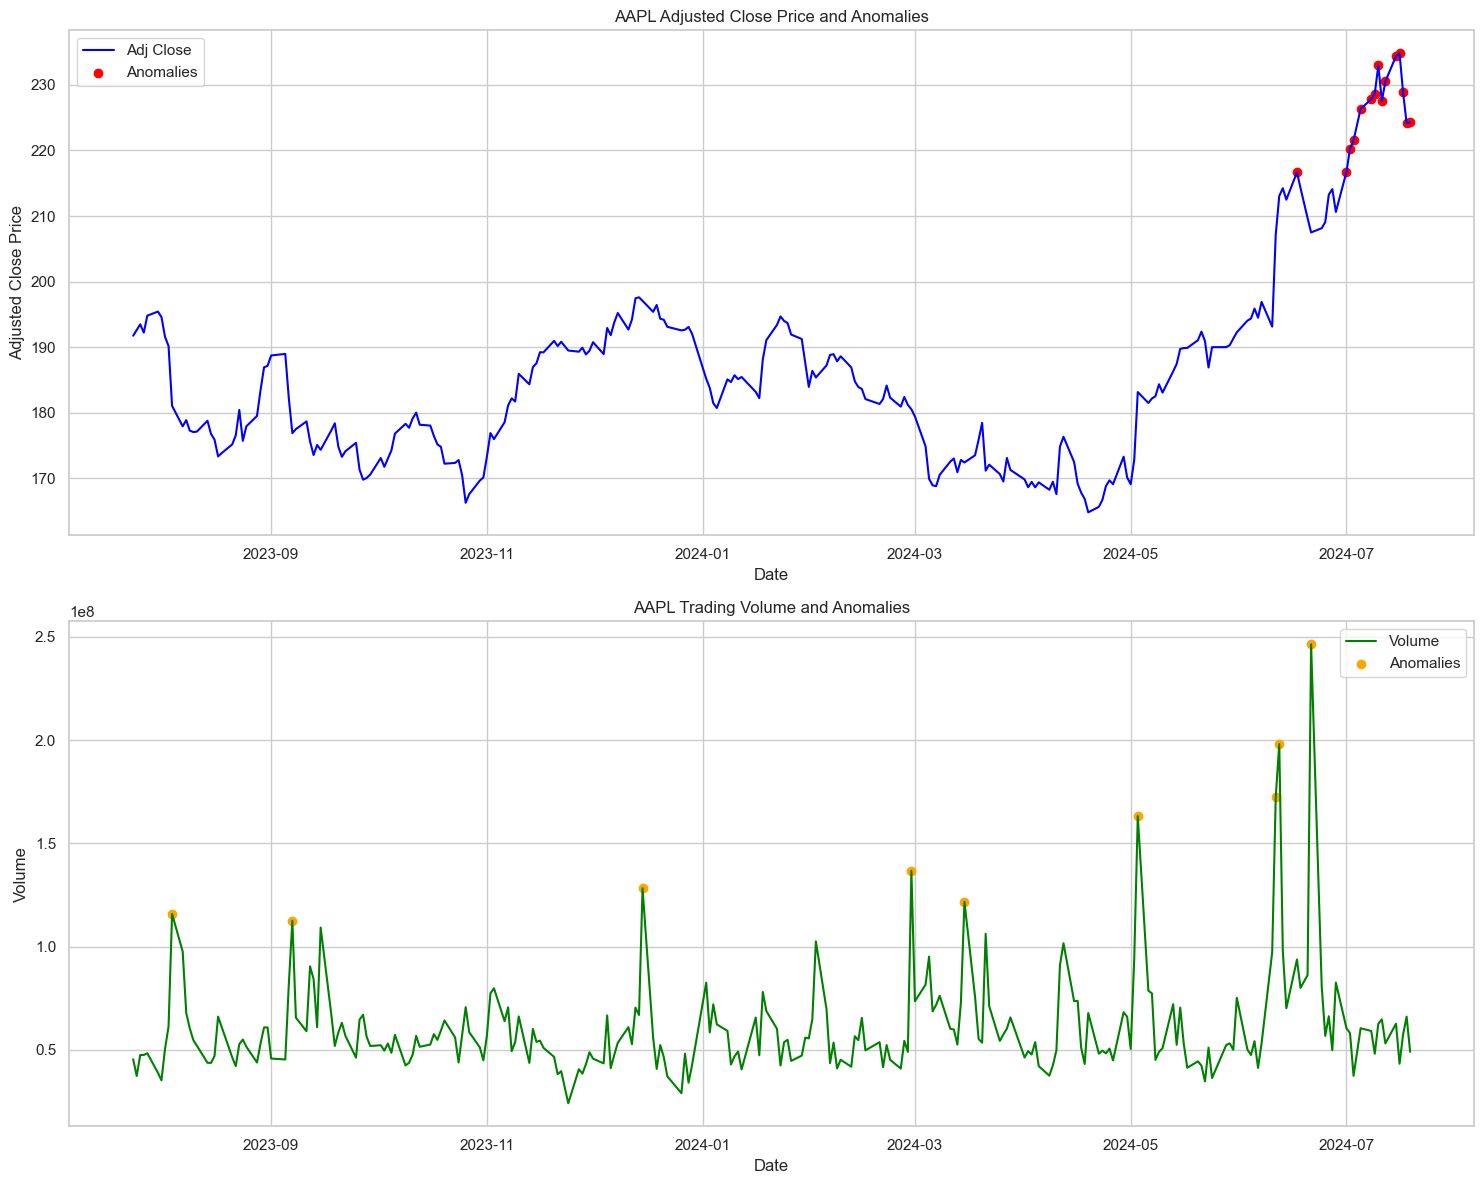

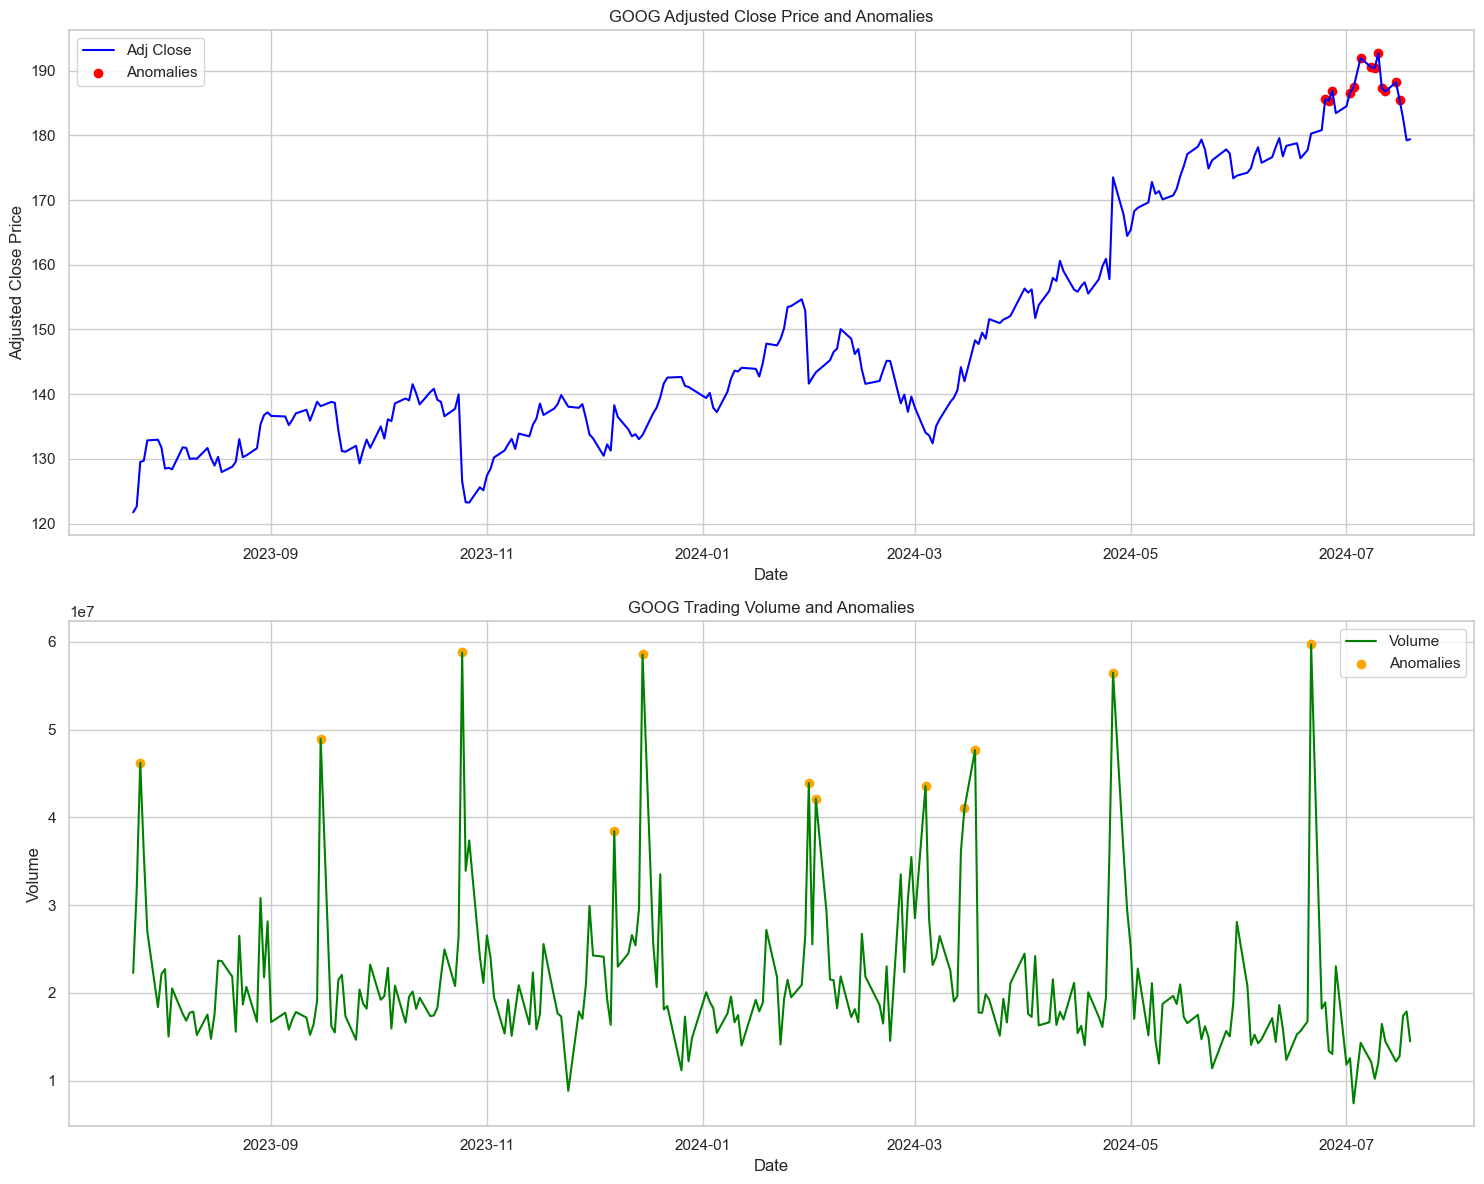

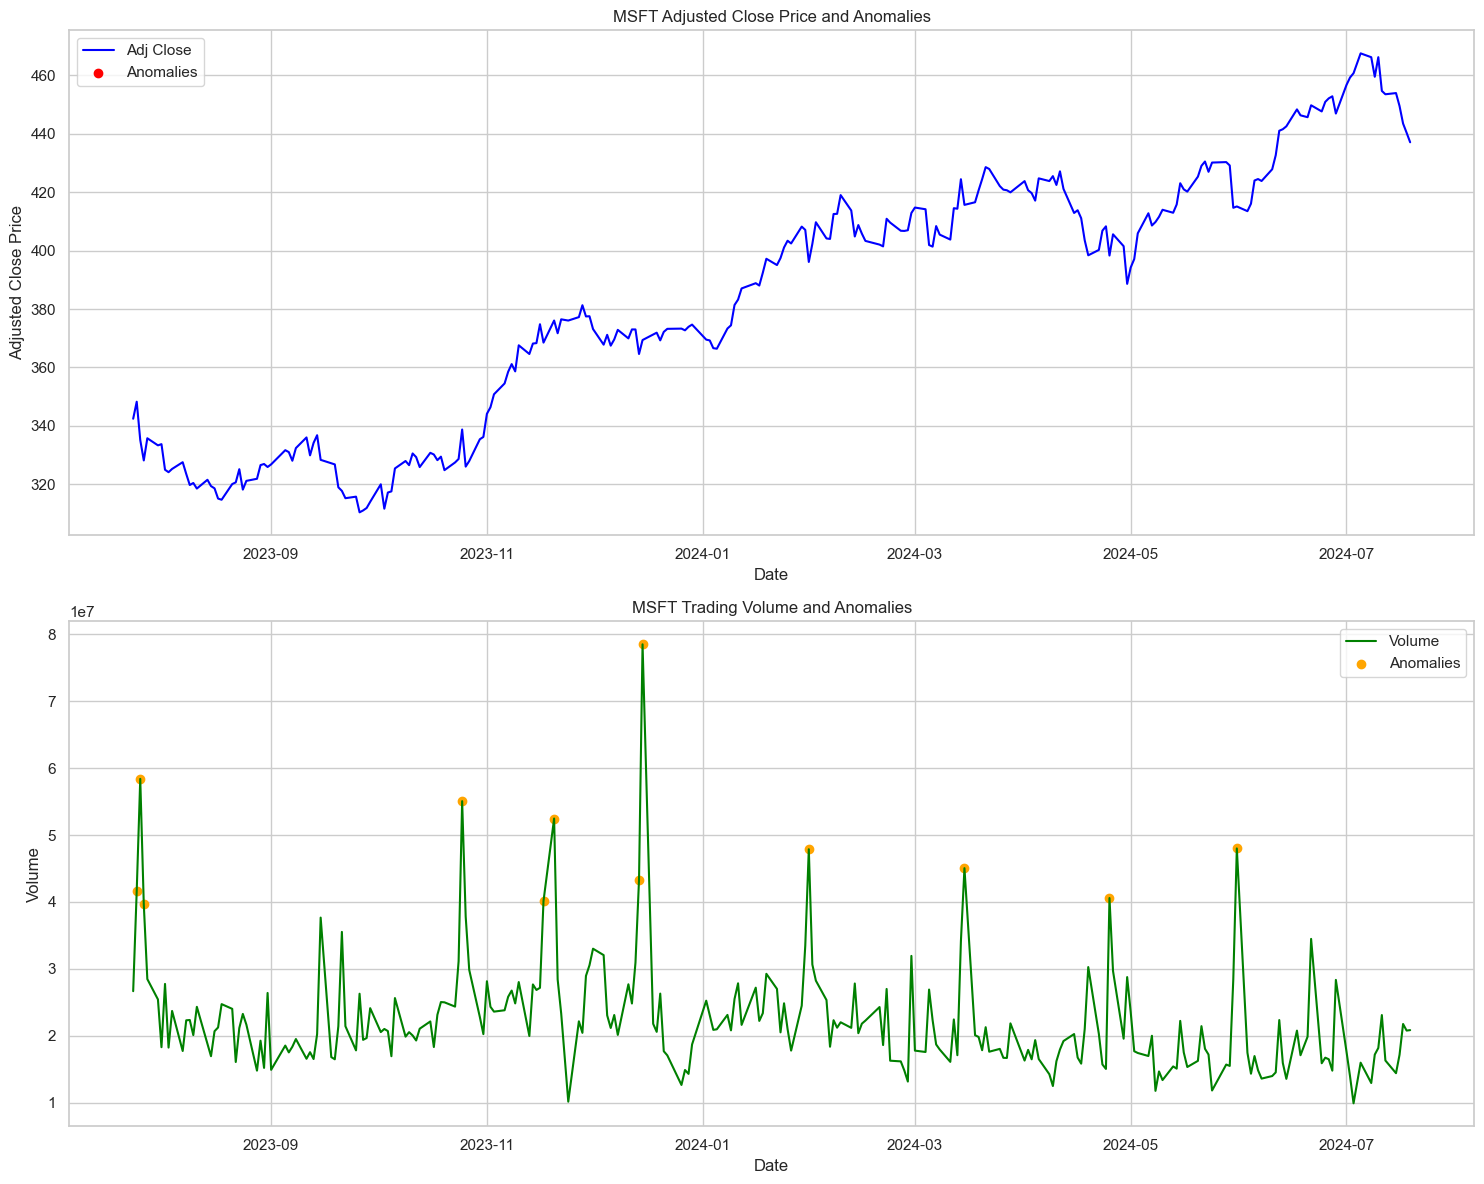

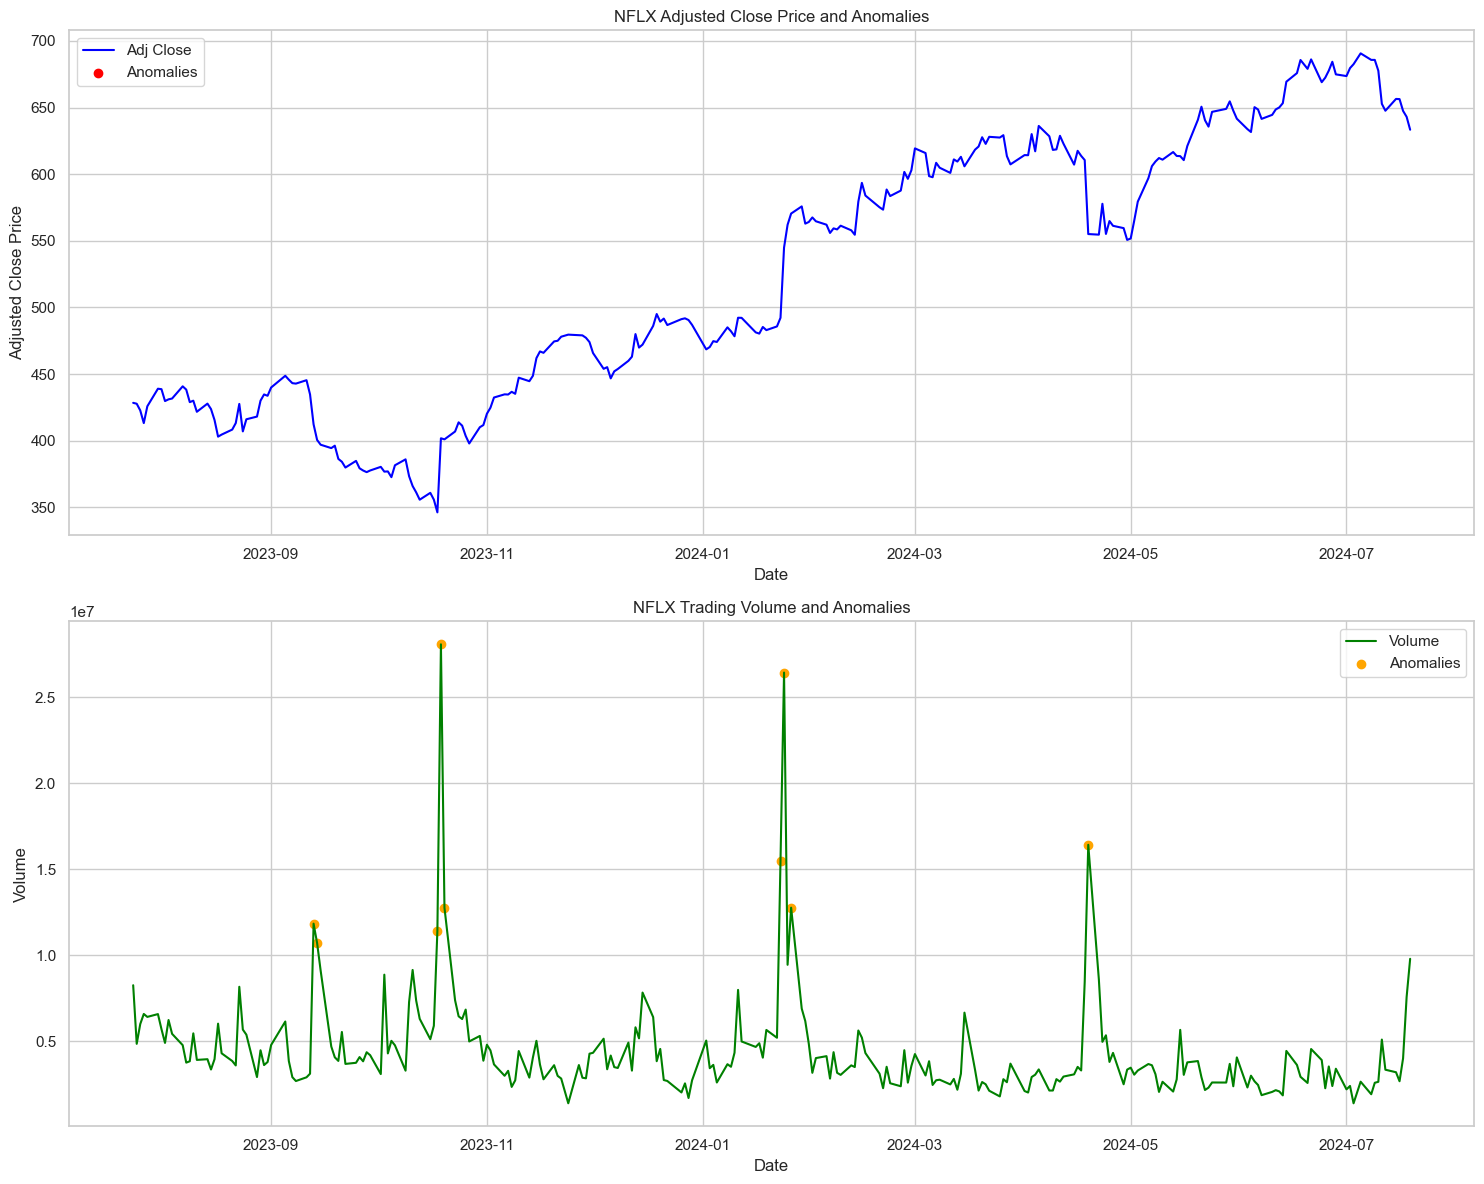

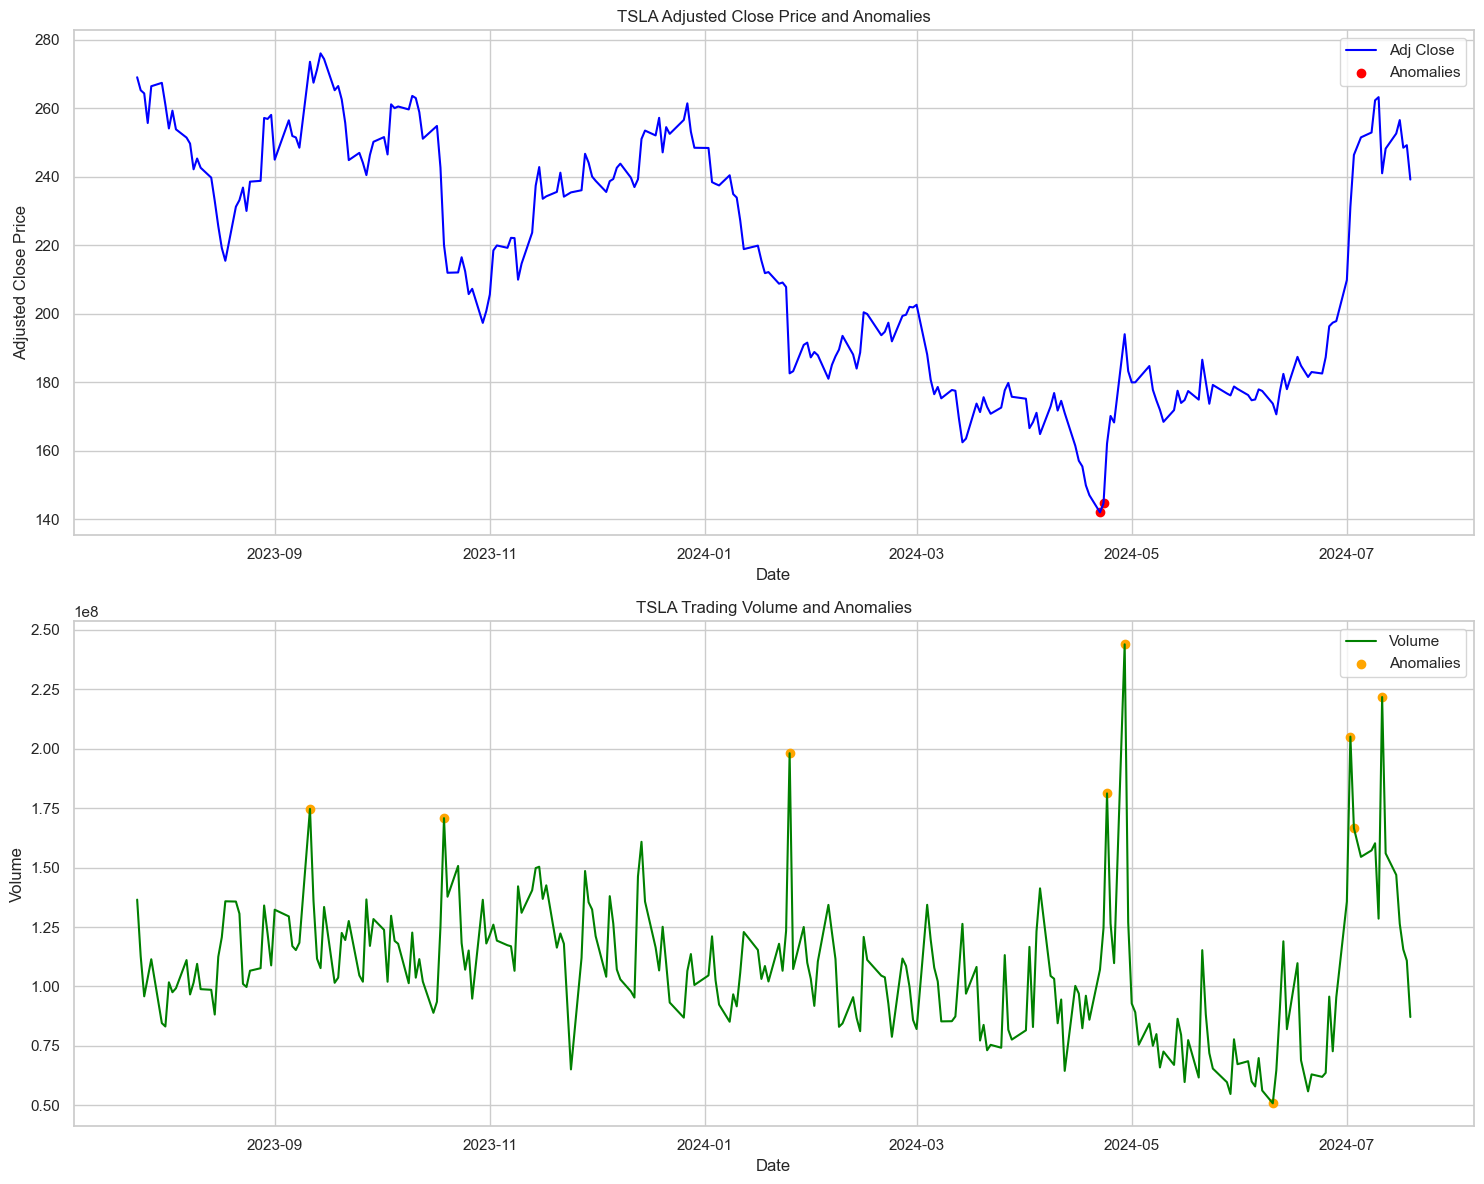

In [18]:
#plot the adjusted close prices and trading volumes again for each company, highlighting the anomalies we detected
def plot_anomalies(ticker, anomalies_adj_close, anomalies_volume):
    # Filter the main and anomalies data for the given ticker
    data_ticker = stock_data[stock_data['Ticker'] == ticker]
    adj_close_anomalies = anomalies_adj_close[anomalies_adj_close['Ticker'] == ticker]
    volume_anomalies = anomalies_volume[anomalies_volume['Ticker'] == ticker]

    # plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

    # adjusted close price
    ax1.plot(data_ticker.index, data_ticker['Adj Close'], label='Adj Close', color='blue')
    ax1.scatter(adj_close_anomalies.index, adj_close_anomalies['Adj Close'], color='red', label='Anomalies')
    ax1.set_title(f'{ticker} Adjusted Close Price and Anomalies')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Close Price')
    ax1.legend()

    # volume
    ax2.plot(data_ticker.index, data_ticker['Volume'], label='Volume', color='green')
    ax2.scatter(volume_anomalies.index, volume_anomalies['Volume'], color='orange', label='Anomalies')
    ax2.set_title(f'{ticker} Trading Volume and Anomalies')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# plot anomalies for each ticker
for ticker in stock_data['Ticker'].unique():
    plot_anomalies(ticker, anomalies_adj_close, anomalies_volume)

In [19]:
#The above charts for each company display the adjusted close prices and trading volumes over time, with anomalies highlighted:

# Anomalies are marked in red and represent significant deviations from the typical price range. 
# These could correspond to days with unexpected news, earnings reports, or market shifts.
# Anomalies in trading volume are marked in orange and indicate days with exceptionally high or low trading activity compared to the norm. 
# Such spikes could be due to market events, announcements, or other factors influencing trader behaviour.

In [20]:
#analyze the correlation in the anomalies of all the companies:
all_anomalies_adj_close = anomalies_adj_close[['Ticker']].copy()
all_anomalies_adj_close['Adj Close Anomaly'] = 1  # indicator variable for anomalies

all_anomalies_volume = anomalies_volume[['Ticker']].copy()
all_anomalies_volume['Volume Anomaly'] = 1  # indicator variable for anomalies

# pivot these dataframes to have one row per date and columns for each ticker, filling non-anomalies with 0
adj_close_pivot = all_anomalies_adj_close.pivot_table(index=all_anomalies_adj_close.index, columns='Ticker',
                                                       fill_value=0, aggfunc='sum')

volume_pivot = all_anomalies_volume.pivot_table(index=all_anomalies_volume.index, columns='Ticker',
                                                fill_value=0, aggfunc='sum')

# flatten the multi-level column index
adj_close_pivot.columns = adj_close_pivot.columns.get_level_values(1)
volume_pivot.columns = volume_pivot.columns.get_level_values(1)

# combine the two pivoted dataframes
combined_anomalies = pd.concat([adj_close_pivot, volume_pivot], axis=1, keys=['Adj Close Anomaly', 'Volume Anomaly'])

# calculate the correlation matrix for the anomalies
correlation_matrix = combined_anomalies.corr()

print(correlation_matrix)

                         Adj Close Anomaly                     Volume Anomaly  \
Ticker                                AAPL      GOOG      TSLA           AAPL   
                  Ticker                                                        
Adj Close Anomaly AAPL            1.000000  0.060523 -0.577350            NaN   
                  GOOG            0.060523  1.000000 -0.454257            NaN   
                  TSLA           -0.577350 -0.454257  1.000000            NaN   
Volume Anomaly    AAPL                 NaN       NaN       NaN       1.000000   
                  GOOG                 NaN       NaN       NaN       0.055048   
                  MSFT                 NaN       NaN       NaN      -0.073398   
                  NFLX                 NaN       NaN       NaN      -0.272727   
                  TSLA                 NaN       NaN       NaN      -0.272727   

                                                                  
Ticker                        GOOG      M

In [21]:
# AAPL has a low positive correlation with GOOG and a negative correlation with NFLX in terms of adjusted close price anomalies. 
# It suggests that price movements in AAPL have some level of simultaneous occurrence with GOOG but move inversely with NFLX.
# On the other hand, GOOG and NFLX show a strong negative correlation, indicating that when one experiences an anomalous price increase (or decrease), 
# the other tends to move in the opposite direction.

# In trading volumes, GOOG shows a positive correlation with MSFT in trading volume anomalies, 
# suggesting that these companies might have simultaneous unusual trading activities. 
# AAPL’s volume anomalies have a negative correlation with other companies like NFLX and TSLA, 
# indicating that when AAPL experiences unusual trading volume, these companies tend to have opposite anomalies in their trading volumes.

In [22]:
# calculate the mean absolute Z-score for each stock as a risk indicator
adj_close_risk = anomalies_adj_close.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())
volume_risk = anomalies_volume.groupby('Ticker')['Z-score'].apply(lambda x: abs(x).mean())

# combine the risk scores from both price and volume anomalies
total_risk = adj_close_risk + volume_risk

# normalize the risk scores to get a relative risk rating from 0 to 1
risk_rating = (total_risk - total_risk.min()) / (total_risk.max() - total_risk.min())

print(risk_rating)

Ticker
AAPL    1.000000
GOOG    0.321144
MSFT         NaN
NFLX         NaN
TSLA    0.000000
Name: Z-score, dtype: float64


In [ ]:
# Here’s the interpretation of each rating:

# AAPL: Has a risk rating of approximately 0.17. It suggests that Apple’s stock shows some level of risk due to anomalies, 
# but it is relatively moderate compared to others like NFLX.

# GOOG: With a risk rating of around 0.06, GOOG appears to be less risky compared to AAPL. 
# It indicates fewer or less significant anomalies in its trading data.

# MSFT: Shows a risk rating of 0.00, indicating the least risk among the stocks listed. 
# It suggests that Microsoft had the fewest and smallest anomalies in its price and volume data.

# NFLX: Has the highest risk rating at 1.00. It indicates that Netflix is the most risky among these stocks, 
# with the most frequent and largest anomalies detected.

# TSLA: The NaN value suggests that it did not have detectable anomalies in the period analyzed.